In [33]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import pathlib
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import requests
# !pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import sys
from tensorflow.keras.optimizers import Adam
# !pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
import segmentation_models as sm
from keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import PIL.Image
import math

# Functions

In [75]:
def get_edge_from_mask(mask):
    m = (mask.squeeze() > 0).astype(np.uint8)
    kernel = np.ones((3,3), np.uint8)
    edge = cv2.morphologyEx(m, cv2.MORPH_GRADIENT, kernel)
    edge = edge.astype(np.float32)
    return edge.reshape(512,512,1)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32) 

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return (intersection + smooth) / (union + smooth)


# Ingest and Process New Dataset

In [79]:
base_dir = r"./Nepal landslide dataset/"

In [80]:
# Ingest images

training_images_list = os.listdir(r"{}Training/image/".format(base_dir))
training_masks_list = []
training_images = []

for n in training_images_list:
    im = PIL.Image.open(r"{}Training/image/{}".format(base_dir, n))
    training_images.append(im)
    # Nepal uses .tiff → label uses .png
    training_masks_list.append(n[:-5] + '.png')
    
# Training masks
training_masks = []
for n in training_masks_list:
    im = PIL.Image.open(r"{}Training/label/{}".format(base_dir, n))
    training_masks.append(im)

# -------------------------
# Test images
# -------------------------
test_images_list = os.listdir(r"{}Test/image/".format(base_dir))
test_images = []

for n in test_images_list:
    im = PIL.Image.open(r"{}Test/image/{}".format(base_dir, n))
    test_images.append(im)

# -------------------------
# Validation images
# -------------------------
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []

for n in validation_images_list:
    im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir, n))
    validation_images.append(im)
    validation_masks_list.append(n[:-5] + '.png')

# Validation masks
validation_masks = []
for n in validation_masks_list:
    im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir, n))
    validation_masks.append(im)


In [81]:
# Pre-process (same as original, only ensure resize)
# -------------------------

# images (3-channel)
for i in range(len(training_images)):
    arr = np.array(training_images[i]) / 255
    arr = cv2.resize(arr, (512, 512))     
    arr = arr.reshape(1, 512, 512, 3)
    training_images[i] = arr.astype('float32')

# masks (1-channel)
for i in range(len(training_masks)):
    arr = np.array(training_masks[i])
    arr = cv2.resize(arr, (512, 512))    
    arr = arr.reshape(1, 512, 512, 1)
    training_masks[i] = arr.astype('int')

training_edges = []
for i in range(len(training_masks)):
    mask = training_masks[i].astype(np.uint8)
    edge = get_edge_from_mask(mask)
    training_edges.append(edge)

# # validation images
for i in range(len(validation_images)):
    arr = np.array(validation_images[i]) / 255
    arr = cv2.resize(arr, (512, 512))
    arr = arr.reshape(1, 512, 512, 3)
    validation_images[i] = arr.astype('float32')

# validation masks
for i in range(len(validation_masks)):
    arr = np.array(validation_masks[i])
    arr = cv2.resize(arr, (512, 512))
    arr = arr.reshape(1, 512, 512, 1)
    validation_masks[i] = arr.astype('int')

validation_edges = []
                          
for i in range(len(validation_masks)):
    mask = validation_masks[i].astype(np.uint8)
    edge = get_edge_from_mask(mask)
    validation_edges.append(edge)

# test images
for i in range(len(test_images)):
    arr = np.array(test_images[i]) / 255
    arr = cv2.resize(arr, (512, 512))
    arr = arr.reshape(1, 512, 512, 3)
    test_images[i] = arr.astype('float32')

In [82]:
validation_Nepal_landslide_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [ ]:

def mask_stats(masks):
    # masks: numpy array (N,H,W,1) or list
    a = np.array(masks)
    if a.ndim==4 and a.shape[-1]==1:
        a = a[...,0]
    flat = a.flatten()
    unique, counts = np.unique(flat, return_counts=True)
    freq = dict(zip(unique.tolist(), counts.tolist()))
    total = flat.size
    print("unique values & counts:", freq)
    print("total pixels:", total)
    for k,v in freq.items():
        print(f"value {k}: {v} pixels, ratio {v/total:.6f}")
    return freq

mask_stats(t_masks)
mask_stats(validation_masks)


In [83]:
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.3] = 1 # FOREST
    mask[mask <= 0.3] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size, images, edges, masks, aug_dict):
    data_gen = ImageDataGenerator(**aug_dict)

    img_gen  = data_gen.flow(images, batch_size=batch_size, seed=1)
    edge_gen = data_gen.flow(edges,  batch_size=batch_size, seed=1)
    mask_gen = data_gen.flow(masks,  batch_size=batch_size, seed=1)

    while True:
        batch_img  = img_gen.next()
        batch_edge = edge_gen.next()
        batch_mask = mask_gen.next()

        yield ([batch_img, batch_edge], batch_mask)


In [84]:
t_images = np.stack(training_images)
t_masks = np.stack(training_masks)
t_images = np.squeeze(t_images, axis=1)
t_edges = np.stack(training_edges)
t_masks  = np.squeeze(t_masks, axis=1)


v_edges = np.stack(validation_edges)
v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)
v_images = np.squeeze(v_images, axis=1)
v_masks  = np.squeeze(v_masks, axis=1)


data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
)

train = trainGenerator(1, t_images, t_edges, t_masks, data_gen_args)

t_images: (230, 512, 512, 3)
t_edges : (230, 512, 512, 1)
t_masks : (230, 512, 512, 1)
v_images: (35, 512, 512, 3)
v_edges : (35, 512, 512, 1)
v_masks : (35, 512, 512, 1)


In [85]:
BETA = 0.95
SMOOTH_TERM = 1e-7

def dice_coef(y_true, y_pred, smooth=SMOOTH_TERM):
    y_true_float = K.cast(y_true, 'float32') 
    
    y_true_f = K.flatten(y_true_float)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# def weighted_bce_loss(y_true, y_pred, beta=BETA):
#     # 🌟 关键步骤：使用 K.cast() 将输入的 y_true (int64) 转换为 float32
#     y_true_float = K.cast(y_true, 'float32') 

#     # 计算标准的二元交叉熵
#     bce = K.binary_crossentropy(y_true_float, y_pred)
    
#     # 权重计算
#     # weight = beta * y_true_float + (1 - beta) * (1 - y_true_float)
#     # 当 y_true=1 (前景) 时，weight=beta
#     # 当 y_true=0 (背景) 时，weight=1-beta
    
#     # K.sum(y_true_float) 是前景像素总数
#     # K.sum(1 - y_true_float) 是背景像素总数
    
#     # 计算每个像素的权重：前景像素权重为 beta，背景像素权重为 1-beta
#     weight = beta * y_true_float + (1.0 - beta) * (1.0 - y_true_float)
    
#     # 对加权后的 BCE 求平均
#     weighted_bce = weight * bce
#     return K.mean(weighted_bce)

# def bce_dice_loss_weighted(y_true, y_pred):
#     # 1. 加权 BCE
#     wbce = weighted_bce_loss(y_true, y_pred)
    
#     # 2. Dice Loss (使用 y_true_float 和调整后的平滑项)
#     dice = dice_loss(y_true, y_pred)
    
#     # 结合两种损失
#     return 0.5*wbce + 0.5*dice

    
def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=2.0):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')


    TP = K.sum(y_true * y_pred)
    FP = K.sum((1 - y_true) * y_pred)
    FN = K.sum(y_true * (1 - y_pred))

    tversky = (TP + 1e-7) / (TP + alpha*FN + beta*FP + 1e-7)
    focal_tversky = K.pow((1 - tversky), gamma)

    return focal_tversky


In [86]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
# class CosineAnnealingScheduler(Callback):
#     def __init__(self, T_max, eta_min=1e-6, verbose=1):
#         super().__init__()
#         self.T_max = T_max
#         self.eta_min = eta_min
#         self.verbose = verbose

#     def on_epoch_begin(self, epoch, logs=None):
#         lr_max = 1e-3
#         lr = self.eta_min + (lr_max - self.eta_min) * (
#             1 + math.cos(math.pi * epoch / self.T_max)) / 2
        
#         tf.keras.backend.set_value(self.model.optimizer.lr, lr)
#         if self.verbose:
#             print(f"Epoch {epoch+1}: LR = {lr}")
# scheduler = CosineAnnealingScheduler(T_max=50, eta_min=1e-6)

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

reduce_lr = ReduceLROnPlateau(
    monitor='val_iou_metric',  # 你的 IoU 指标名字
    mode='max',                # IoU 越大越好
    factor=0.5,
    patience=7,
    verbose=1,
    min_lr=1e-7
)


# Models

## U-Net

In [87]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    input_img = Input((512,512,3))
    input_edge = Input((512,512,1))
    inputs = Concatenate(axis=-1)([input_img, input_edge])

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model([input_img, input_edge], conv10)

    # model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
    model.compile(optimizer = Adam(learning_rate = lr), loss = focal_tversky_loss, metrics = ['accuracy', iou_metric])
    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [88]:
# Print model layers and number of parameters
UNet().summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_57 (InputLayer)          [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_101 (Concatenate)  (None, 512, 512, 4)  0           ['input_56[0][0]',               
                                                                  'input_57[0][0]']        

## Attention U-Net

In [93]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)

    # match spatial size
    upsample_g = UpSampling2D(size=(theta_x.shape[1] // phi_g.shape[1],
                                    theta_x.shape[2] // phi_g.shape[2]), 
                              interpolation='bilinear')(phi_g)

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    psi = Activation('sigmoid')(psi)

    # upsample attention mask to match x
    psi_up = UpSampling2D(size=(x.shape[1] // psi.shape[1],
                                x.shape[2] // psi.shape[2]), 
                          interpolation='bilinear')(psi)

    # apply attention
    y = multiply([x, psi_up])
    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    input_img = Input((512,512,3))
    input_edge = Input((512,512,1))
    inputs = Concatenate(axis=-1)([input_img, input_edge])


    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
# 应该合并上采样输出和注意力加权后的跳跃连接
    conv7 = concatenate([up7, merge7]) 
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model([input_img, input_edge], out)

    # model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
    model.compile(optimizer = Adam(learning_rate = lr), loss = focal_tversky_loss, metrics = ['accuracy', iou_metric])
    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [94]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_64 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_65 (InputLayer)          [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_116 (Concatenate)  (None, 512, 512, 4)  0           ['input_64[0][0]',               
                                                                  'input_65[0][0]']        

# Train on New feature data

In [56]:
# Train U-Net with generator
model_unet = UNet(lr=0.000025)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_iou_metric',verbose=1, save_best_only=True, mode='max')


train = trainGenerator(1, t_images, t_edges, t_masks, data_gen_args)
model_unet.fit(
    train,
    steps_per_epoch=230,
    epochs=50,
    validation_data=([v_images, v_edges], v_masks),
    callbacks=[save_model, reduce_lr]
)

Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.9594 - iou_metric: 0.4306
Epoch 1: val_iou_metric improved from -inf to 0.48742, saving model to unet-3d.hdf5
230/230 [==============================] - 20s 80ms/step - loss: 0.2889 - accuracy: 0.9594 - iou_metric: 0.4306 - val_loss: 0.0564 - val_accuracy: 0.9904 - val_iou_metric: 0.4874 - lr: 2.5000e-05
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9958 - iou_metric: 0.6654
Epoch 2: val_iou_metric improved from 0.48742 to 0.63478, saving model to unet-3d.hdf5
230/230 [==============================] - 18s 78ms/step - loss: 0.0353 - accuracy: 0.9958 - iou_metric: 0.6654 - val_loss: 0.0259 - val_accuracy: 0.9948 - val_iou_metric: 0.6348 - lr: 2.5000e-05
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9966 - iou_metric: 0.7172
Epoch 3: val_iou_metric improved from 0.63478 to 0.63623, saving model to unet-3d.hdf5

In [57]:
# Save model training history
np.save('unet-3d-history.npy',model_unet.history.history)

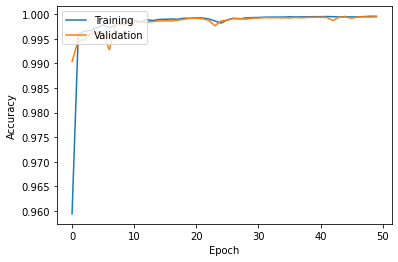

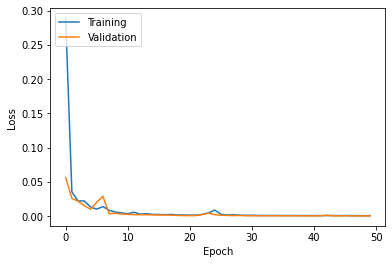

In [58]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

## Attention U-Net

In [100]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(input_size=(512, 512, 3), lr = 0.000055, filter_base=16)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_iou_metric',verbose=1, save_best_only=True, mode='max' )

train = trainGenerator(1, t_images, t_edges, t_masks, data_gen_args)

model_attention_unet.fit(
    train,
    steps_per_epoch=230,
    epochs=100,
    validation_data=([v_images, v_edges], v_masks),
    callbacks=[save_model, reduce_lr]
)

Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.8778 - iou_metric: 0.2257
Epoch 1: val_iou_metric improved from -inf to 0.59617, saving model to unet-3d.hdf5
230/230 [==============================] - 19s 75ms/step - loss: 0.6176 - accuracy: 0.8778 - iou_metric: 0.2257 - val_loss: 0.0592 - val_accuracy: 0.9944 - val_iou_metric: 0.5962 - lr: 5.5000e-05
Epoch 2/100
230/230 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9920 - iou_metric: 0.6075
Epoch 2: val_iou_metric improved from 0.59617 to 0.64388, saving model to unet-3d.hdf5
230/230 [==============================] - 17s 74ms/step - loss: 0.0581 - accuracy: 0.9920 - iou_metric: 0.6075 - val_loss: 0.0302 - val_accuracy: 0.9950 - val_iou_metric: 0.6439 - lr: 5.5000e-05
Epoch 3/100
229/230 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9943 - iou_metric: 0.6563
Epoch 3: val_iou_metric did not improve from 0.64388
230/230 [=====================

In [137]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

# Import Models and Compute Metrics

## RGB

In [146]:
# Load 3-dim models and history stats
attention_unet = load_model(
    'unet-attention-3d.hdf5',
    custom_objects={
        'iou_metric': iou_metric,
        'focal_tversky_loss': focal_tversky_loss
    }
)

unet = load_model(
    'unet-3d.hdf5',
    custom_objects={'iou_metric': iou_metric,
                    'focal_tversky_loss': focal_tversky_loss
                   }
)

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_462 (Conv2D)            (1, 512, 512, 16)    448         ['input_23[0][0]']               
                                                                                                  
 activation_502 (Activation)    (1, 512, 512, 16)    0           ['conv2d_462[0][0]']             
                                                                                                  
 conv2d_463 (Conv2D)            (1, 512, 512, 16)    2320        ['activation_502[0][0]']         
                                                                                           

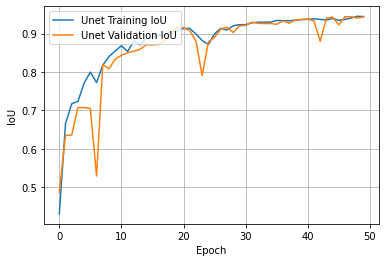

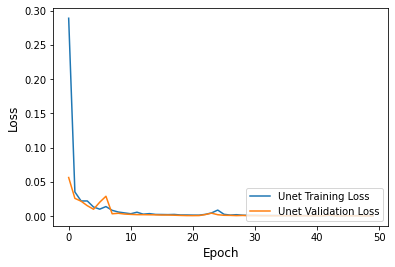

In [140]:
# Plot accuracy and loss for U-Net

## Accuracy

plt.plot(unet_history['iou_metric'])
plt.plot(unet_history['val_iou_metric'])

plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Unet Training IoU', 'Unet Validation IoU'], loc='upper left')
plt.grid(True)
plt.show()


## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Unet Training Loss', 'Unet Validation Loss'], loc='lower right')

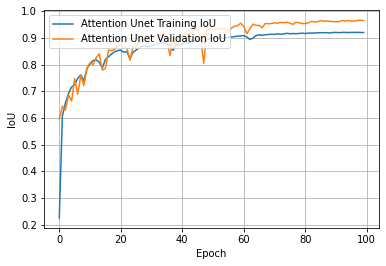

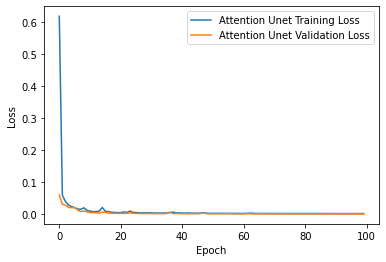

In [141]:
# Plot accuracy and loss for Attention U-Net

## Accuracy

plt.plot(attention_unet_history['iou_metric'])
plt.plot(attention_unet_history['val_iou_metric'])

plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Attention Unet Training IoU', 'Attention Unet Validation IoU'], loc='upper left')
plt.grid(True)
plt.show()


## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Attention Unet Training Loss', 'Attention Unet Validation Loss'], loc='upper right')